<hr>
<center><b>Machine learning sur les données tabmo</center> <br>
<center><b>Over sampling </center> <br>
<hr>



# Objectif 

# Import

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.preprocessing import scale, StandardScaler, normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.svm import SVC, LinearSVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
sns.set(style="whitegrid")

# Data import & exploration

In [22]:
read_df = pd.read_csv("data.csv", low_memory=False)
read_df, valid = train_test_split(read_df, test_size=0.05, random_state = 42)
print("Taille :", read_df.shape,
     "\nVariables :", read_df.columns) 

Taille : (87453, 78) 
Variables : Index(['auction_id', 'click', 'exchange', 'app_or_site', 'has_gps',
       'device_type', 'connection_type', 'creative_size', 'has_ifa',
       'win_price', 'win_price_loc', 'bidder_name', 'Device_language',
       'Country_language', 'Device_lg_Equals_country_lg', 'Continent',
       'Country_name', 'City', 'Timestamp', 'IAB1', 'IAB1%', 'IAB10', 'IAB11',
       'IAB12', 'IAB13', 'IAB14', 'IAB15', 'IAB16', 'IAB17', 'IAB18', 'IAB19',
       'IAB2', 'IAB20', 'IAB21', 'IAB22', 'IAB23', 'IAB24', 'IAB26', 'IAB3',
       'IAB3%', 'IAB4', 'IAB5', 'IAB6', 'IAB7', 'IAB8', 'IAB9', 'IAB9%',
       'books', 'busin', 'educa', 'enter', 'finan', 'games', 'healt', 'lifes',
       'medic', 'music', 'navig', 'news', 'photo', 'produ', 'refer', 'socia',
       'sport', 'trave', 'unkno', 'utili', 'weath', 'fullOsInfo',
       'Timestamp_second', 'Timestamp_minute', 'Timestamp_hour',
       'Timestamp_DayOfWeek', 'Timestamp_DayOfMonth', 'Timestamp_Month',
       'Days_Since

# Data cleaning

In [0]:
def cleaning(df,frac=1):
  df = df.drop(['auction_id', 'win_price_loc', 'Campaign_Duration',
          'Timestamp', 'Timestamp_Month'],axis = 1)
  creative_size = df['creative_size'].str.split('x',expand=True)
  df['creative_size1'] = creative_size[0]
  df['creative_size2'] = creative_size[1]
  df['win_price'] = pd.qcut(df["win_price"],10)
  df.drop("creative_size", axis=1, inplace=True)
  y_0_X = df[df['click'] == 0]
  y_0_X_reduced = y_0_X.sample(frac=frac)
  return pd.concat([y_0_X_reduced,df[df['click'] == 1]])

df = cleaning(read_df,frac=1)

In [24]:
df.head()

,click,exchange,app_or_site,has_gps,device_type,connection_type,has_ifa,win_price,bidder_name,Device_language,Country_language,Device_lg_Equals_country_lg,Continent,Country_name,City,IAB1,IAB1%,IAB10,IAB11,IAB12,IAB13,IAB14,IAB15,IAB16,IAB17,IAB18,IAB19,IAB2,IAB20,IAB21,IAB22,IAB23,IAB24,IAB26,IAB3,IAB3%,IAB4,IAB5,IAB6,IAB7,IAB8,IAB9,IAB9%,books,busin,educa,enter,finan,games,healt,lifes,medic,music,navig,news,photo,produ,refer,socia,sport,trave,unkno,utili,weath,fullOsInfo,Timestamp_second,Timestamp_minute,Timestamp_hour,Timestamp_DayOfWeek,Timestamp_DayOfMonth,Days_Since_Campaign_Starts,Days_Before_Campaign_Ends,creative_size1,creative_size2
38494,0,rubicon,site,False,1,unknown,False,"(0.18, 0.38]",butor,en,ar,False,Asia,Yemen,Aden,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Android6,49,49,23,5,21,9,40,300,250
49059,0,appnexus,site,False,4,unknown,False,"(4.571, 9.42]",butor,de,ar,False,Asia,Yemen,Aden,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Androidunknown,1,54,9,5,21,21,24,320,480
89334,0,rubicon,site,False,1,unknown,False,"(9.42, 109.122]",butor,fr,ar,False,Asia,Yemen,Aden,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,iOS12,16,41,20,1,3,14,0,728,90
55249,0,doubleclick,site,False,4,unknown,False,"(-0.001, 0.09]",albatros,unknown,ar,False,Asia,Yemen,Aden,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Androidunknown,33,21,13,4,27,3,3,300,250
69189,0,mopub,app,True,4,2,True,"(0.38, 1.101]",butor,en,en,True,Europe,United Kingdom,London,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,iOS12,12,48,20,4,13,24,1,300,250


## Get Labels values

In [0]:
y = df['click']
X = pd.get_dummies(df.drop(['click'],axis =1))

## SVD for dimensionnal reduction

In [26]:
svd = TruncatedSVD(n_components=15, n_iter=7)
X_normalized = normalize(X) # Normalize before svd
X_transformed = svd.fit_transform(X_normalized)
print("Pourcentage d'inertie : ", svd.explained_variance_ratio_.sum())

Pourcentage d'inertie :  0.9928578990003659


In [27]:
## Concatenate dataframe for modelization
X = preprocessing.normalize(pd.DataFrame(X_transformed))
print("Shape before SVD : ", pd.DataFrame(X_normalized).shape, "\nShape after SVD : ", X.shape)

Shape before SVD :  (87453, 386) 
Shape after SVD :  (87453, 15)


## Train & test sample split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size = 0.15, random_state = 42)

# Labels repartition

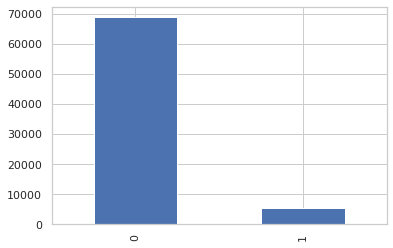

In [29]:
y_train.value_counts().plot(kind = 'bar')
weight_0 = y_train.shape[0]/(2*df["click"].value_counts()[0])
weight_1 = y_train.shape[0]/(2*df["click"].value_counts()[1])

In [30]:
print("poids label 0 : " ,weight_0, " & poid label 1 : ", weight_1)

poids label 0 :  0.4584561680502276  & poid label 1 :  5.823801316201817


# Oversampling

In [31]:
smote_enn=SMOTETomek(random_state=42)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


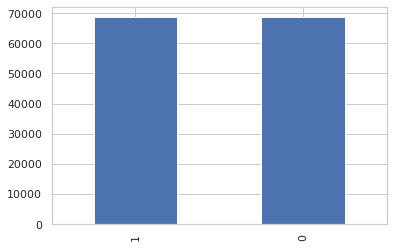

In [32]:
pd.Series(y_train).value_counts().plot(kind = 'bar')

# Les  modèles testés

In [0]:
lsvm=LinearSVC(penalty='l2', 
          loss='hinge', 
          dual=True, 
          tol=0.1,
          C=1,
          fit_intercept=True,
          class_weight="balanced",
          max_iter=100,
          intercept_scaling=1
          )

lr=rfe = RFE(LogisticRegression(solver='newton-cg',
                                  fit_intercept=True,
                                  class_weight = "balanced",
                                  C=1,
                                  tol=0.1,
                                  penalty='l2',
                                  intercept_scaling=1)) 

dtc=DecisionTreeClassifier(random_state=42,
                             max_features="auto", 
                             class_weight="balanced",
                             criterion="entropy",
                             splitter="random",
                             max_depth=100)

abc=AdaBoostClassifier(base_estimator = dtc, n_estimators = 100)

gnb=GaussianNB()


mlp=MLPClassifier(hidden_layer_sizes=(15, 30, 18, 1),
                    alpha=1e-05,
                    activation="tanh",
                    solver="adam",
                    random_state=42, 
                    max_iter=10000, 
                    warm_start=True)

In [0]:
# Fit
lsvm.fit(X_train, y_train)
lr.fit(X_train, y_train)
abc.fit(X_train, y_train)
gnb.fit(X_train, y_train)
mlp.fit(X_train, y_train)

# Predict
pred_lsvm=lsvm.predict(X_test)
pred_lr=lr.predict(X_test)
pred_abc=abc.predict(X_test)
pred_gnb=gnb.predict(X_test)
pred_mlp=mlp.predict(X_test)

# Validation test sample

In [37]:
print("Linear Support Vector Machines \n\n ")
print("Le score est : ", lsvm.score(X_test, y_test))
print("Le score sur le jeu d'apprentissage est de :", lsvm.score(X_train,y_train))
print("Le score sur le jeu de test est de :", lsvm.score(X_test,y_test))
print(metrics.classification_report(y_test, pred_lsvm))
print("\nMatrice de confusion")
print(metrics.confusion_matrix(y_test, pred_lsvm))
print("_____________________________________________________________")


print("\n\nLogistic Regression \n\n ")
print("Le score est : ", lr.score(X_test, y_test))
print("Le score sur le jeu d'apprentissage est de :", lr.score(X_train,y_train))
print("Le score sur le jeu de test est de :", lr.score(X_test,y_test))
print(metrics.classification_report(y_test, pred_lr))
print("\nMatrice de confusion")
print(metrics.confusion_matrix(y_test, pred_lr))
print("_____________________________________________________________")


print("\n\nAdaBoostClassifier \n\n ")
print("Le score est : ", abc.score(X_test, y_test))
print("Le score sur le jeu d'apprentissage est de :", abc.score(X_train,y_train))
print("Le score sur le jeu de test est de :", abc.score(X_test,y_test))
print(metrics.classification_report(y_test, pred_abc))
print("\nMatrice de confusion")
print(metrics.confusion_matrix(y_test, pred_abc))
print("_____________________________________________________________")


print("\n\nGaussian Naive Bayes  \n\n ")
print("Le score est : ", gnb.score(X_test, y_test))
print("Le score sur le jeu d'apprentissage est de :", gnb.score(X_train,y_train))
print("Le score sur le jeu de test est de :", gnb.score(X_test,y_test))
print(metrics.classification_report(y_test, pred_gnb))
print("\nMatrice de confusion")
print(metrics.confusion_matrix(y_test, pred_gnb))
print("_____________________________________________________________")


print("\n\nMulti Layers Perceptron\n\n ")
print("Le score est : ", mlp.score(X_test, y_test))
print("Le score sur le jeu d'apprentissage est de :", mlp.score(X_train,y_train))
print("Le score sur le jeu de test est de :", mlp.score(X_test,y_test))
print(metrics.classification_report(y_test, pred_mlp))
print("\nMatrice de confusion")
print(metrics.confusion_matrix(y_test, pred_mlp))
print("_____________________________________________________________")


Linear Support Vector Machines 

 
Le score est :  0.7291507851806678
Le score sur le jeu d'apprentissage est de : 0.7508775507231601
Le score sur le jeu de test est de : 0.7291507851806678
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     12164
           1       0.17      0.73      0.28       954

    accuracy                           0.73     13118
   macro avg       0.57      0.73      0.56     13118
weighted avg       0.91      0.73      0.79     13118


Matrice de confusion
[[8869 3295]
 [ 258  696]]
_____________________________________________________________


Logistic Regression 

 
Le score est :  0.7255679219393201
Le score sur le jeu d'apprentissage est de : 0.7475566948745211
Le score sur le jeu de test est de : 0.7255679219393201
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     12164
           1       0.17      0.73      0.28       954

    accuracy               

# Validation test sample

In [38]:
# Same cleaning 
valid_df = cleaning(valid)
y_valid = valid_df['click']
X_valid = pd.get_dummies(valid_df.drop(['click'],axis =1))
svd = TruncatedSVD(n_components=15, n_iter=7)
X_valid_normalized = normalize(X_valid) # Normalize before svd
X_valid_transformed = svd.fit_transform(X_valid_normalized)
X_valid = preprocessing.normalize(pd.DataFrame(X_valid_transformed))

# Predict on validation sample
pred_lsvm_valid = lsvm.predict(X_valid)
pred_lr_valid = lr.predict(X_valid)
pred_abc_valid = abc.predict(X_valid)
pred_gnb_valid = gnb.predict(X_valid)
pred_mlp_valid = mlp.predict(X_valid)


# Results
print("Linear Support Vector Machines \n\n ")
print("Le score est : ", lsvm.score(X_valid,y_valid))
print("Le score sur le jeu de validation est de :", lsvm.score(X_valid,y_valid))
print(metrics.classification_report(y_valid, pred_lsvm_valid))
print("\nMatrice de confusion")
print(metrics.confusion_matrix(y_valid, pred_lsvm_valid))
print("_____________________________________________________________")

print("\n\nLogistic Regression \n\n ")
print("Le score est : ", lr.score(X_valid,y_valid))
print("Le score sur le jeu de validation est de :", lr.score(X_valid,y_valid))
print(metrics.classification_report(y_valid, pred_lr_valid))
print("\nMatrice de confusion")
print(metrics.confusion_matrix(y_valid, pred_lr_valid))
print("_____________________________________________________________")


print("\n\nAdaBoostClassifier \n\n ")
print("Le score est : ", abc.score(X_valid,y_valid))
print("Le score sur le jeu de validation est de :", abc.score(X_valid,y_valid))
print(metrics.classification_report(y_valid, pred_abc_valid))
print("\nMatrice de confusion")
print(metrics.confusion_matrix(y_valid, pred_abc_valid))
print("_____________________________________________________________")


print("\n\nGaussian Naive Bayes  \n\n ")
print("Le score est : ", gnb.score(X_valid,y_valid))
print("Le score sur le jeu de validation est de :", gnb.score(X_valid,y_valid))
print(metrics.classification_report(y_valid, pred_gnb_valid))
print("\nMatrice de confusion")
print(metrics.confusion_matrix(y_valid, pred_gnb_valid))
print("_____________________________________________________________")


print("\n\nMulti Layers Perceptron \n\n ")
print("Le score est : ", mlp.score(X_valid,y_valid))
print("Le score sur le jeu de validation est de :", mlp.score(X_valid,y_valid))
print(metrics.classification_report(y_valid, pred_mlp_valid))
print("\nMatrice de confusion")
print(metrics.confusion_matrix(y_valid, pred_mlp_valid))
print("_____________________________________________________________")


Linear Support Vector Machines 

 
Le score est :  0.728003475993917
Le score sur le jeu de validation est de : 0.728003475993917
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      4235
           1       0.19      0.71      0.29       368

    accuracy                           0.73      4603
   macro avg       0.58      0.72      0.56      4603
weighted avg       0.90      0.73      0.79      4603


Matrice de confusion
[[3090 1145]
 [ 107  261]]
_____________________________________________________________


Logistic Regression 

 
Le score est :  0.7223549858787747
Le score sur le jeu de validation est de : 0.7223549858787747
              precision    recall  f1-score   support

           0       0.97      0.72      0.83      4235
           1       0.18      0.71      0.29       368

    accuracy                           0.72      4603
   macro avg       0.57      0.72      0.56      4603
weighted avg       0.90      0.72    